In [1]:
%matplotlib inline
import sys
sys.path.append('/users/fatima/Desktop/code/python/imaka')
from imaka.analysis import plot_stats
root_dir = "/Users/fatima/data/imaka/RUN5/20170518/FLI/"; stack_dir = root_dir + "reduce/stacks/"

/anaconda/lib/python3.6/site-packages/astropy/config/configuration.py:541: ConfigurationMissingWarning: Configuration defaults will be used due to FileExistsError:17 on None
  warn(ConfigurationMissingWarning(msg))


# PSF Variability over Field of View

This preliminary analysis of PSF variability over the field of view shows no correlation between position on the field and either PSF size or elongation.  The plots below were generated from a stack of images from 20170518, with each data point representing one star in the stacked image.  For the scatter plots (the lower two of each set of four), the data are restricted to showing points within two standard deviations of the average.  The first set of four plots are open loop, and the second four are closed.

## Open Loop

/users/fatima/Desktop/code/python/imaka/imaka/analysis/plot_stats.py:1333: RuntimeWarning: invalid value encountered in double_scalars
  elon.append(x_fwhm[i]/y_fwhm[i])


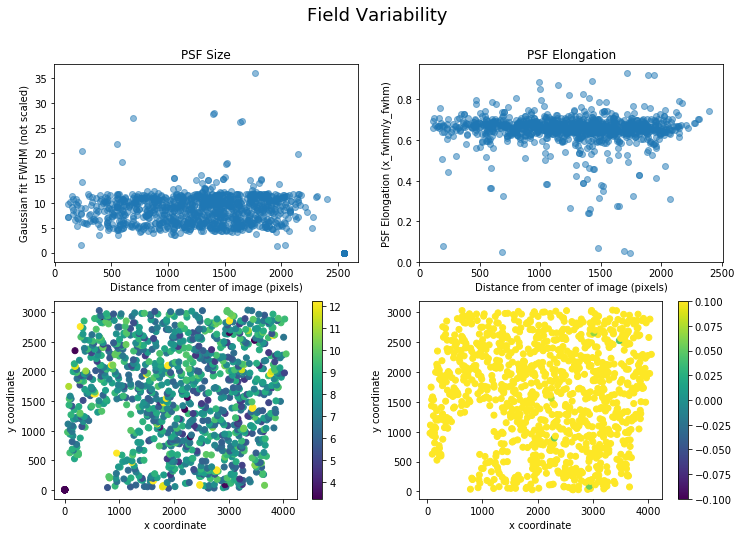

In [2]:
open_starlist = stack_dir+"FLD2_2_stack_open_stars.txt"; open_image = stack_dir + "FLD2_2_stack_open.fits" 
plot_stats.plot_field_var(open_starlist)

## Closed Loop

/users/fatima/Desktop/code/python/imaka/imaka/analysis/plot_stats.py:1333: RuntimeWarning: invalid value encountered in double_scalars
  elon.append(x_fwhm[i]/y_fwhm[i])


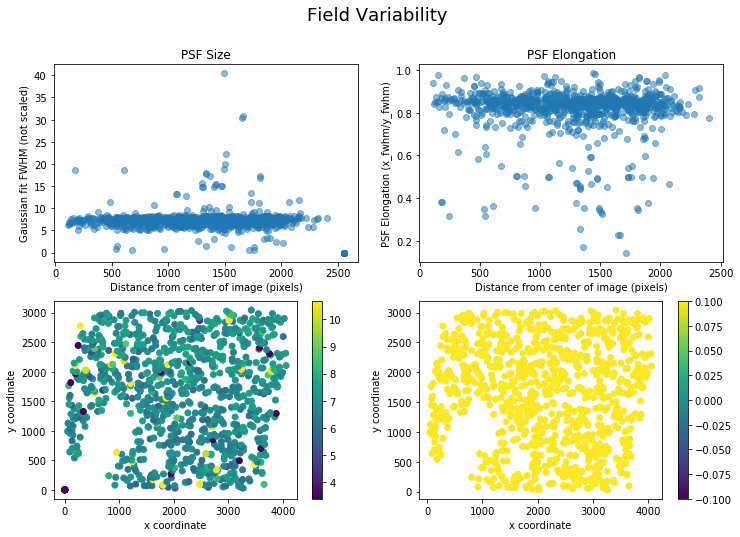

In [3]:
closed_starlist = stack_dir+"FLD2_2_stack_closed_stars.txt"; closed_image = stack_dir + "FLD2_stack_2_closed.fits"
plot_stats.plot_field_var(closed_starlist)